In [62]:
import numpy as np
import tonic
import tonic.transforms as transforms
from torchvision import transforms as tt
import pandas as pd
from torch.utils.data import Dataset, DataLoader
#from tonic.dataset import Dataset
from typing import Callable, Optional
import torch
from torch import nn
import matplotlib.pyplot as plt
from torchvision.ops import masks_to_boxes
from torchvision.utils import draw_bounding_boxes
from typing import Tuple
from tqdm.notebook import tqdm
from statistics import mean

import snntorch as snn

# ##STDP rule for learning on device
local learning
focus on updatability, how can we update the model on small hardware
Add a new class to 
Try low class count - is object in path of robot? Does path need to change

Make algo to make memory efficient updates on model after already learning through backprop

In [63]:
from torchvision.ops import box_iou

In [64]:
import sys
sys.path.append("./mnist_sg_cnn")

In [65]:
import utils
import snn_utils
import base_model
import lenet_decolle_model

### Notes
 - 2/14/2024
   - May be extremely memory intensive for image segmentation with local learning rule. Would have to return entire mask at each readout layer, 30000 params for even a small mask


In [66]:
dir = "/media/user/EVIMO/raw/imo/eval/scene15_dyn_test_01/left_camera/ground_truth_000000"
cache_dir = "./data/EVIMO/obj_det_cache"
sensor_size = [640, 480, 2]
batch_size = 4
num_bins_per_frame = 8 # T = 100
framerate = 200
epochs=20
output_size=(30, 40)
input_size=(480, 640)
num_classes = 25

dtype=torch.float

device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
device

device(type='cuda')

In [67]:
class EVIMOMask(Dataset):
    def __init__(self,
                 dir: str,
                 num_bins_per_frame: int,
                 output_size: Tuple,
                ):
        self.dir = dir
        self.num_bins_per_frame = num_bins_per_frame
        self.output_size = output_size
        self.length = np.load(self.dir + "/length.npy")

        
        #print(self.length)
        #self.start_idx = start_idx


    def __getitem__(self, index):
        item = np.load(self.dir + "/" + str(index) + ".npy", allow_pickle=True).tolist()


        events = np.asarray(item["events"])

        frame_transform = transforms.Compose([# transforms.Denoise(filter_time=0.01),
                                       transforms.ToVoxelGrid(sensor_size=sensor_size,
                                                          n_time_bins=self.num_bins_per_frame)
                                      ])

        events = frame_transform(events)

        mask = torch.from_numpy(np.asarray([item["mask"]])).to(torch.int64)

        one_hot_mask = torch.nn.functional.one_hot(mask, num_classes=num_classes).transpose(1, 3).transpose(2, 3) # Conversion into Batch, Channels, H, W

        # Downsize the mask.
        resized_mask = tt.functional.resize(one_hot_mask, self.output_size, antialias=True)
        
        return torch.from_numpy(events).to(torch.float), resized_mask.squeeze()

    def get_original_mask(self, index):
        item = np.load(self.dir + "/" + str(index) + ".npy", allow_pickle=True).tolist()
        mask = torch.from_numpy(np.asarray([item["mask"]])).to(torch.int64)
        return mask

    def __len__(self) -> int:
        return self.length # - self.start_idx

    def get_item(self, index):
        item = np.load(self.dir + "/" + str(index) + ".npy", allow_pickle=True).tolist()
        return item
    
    

In [68]:
dataset = EVIMOMask(dir="./data/EVIMO/left_cam/scene13_test5", output_size=output_size, num_bins_per_frame=num_bins_per_frame)

In [69]:
e, mask = dataset[0]

In [70]:
num_output_elements = torch.numel(mask)
mask.shape, num_output_elements

(torch.Size([25, 30, 40]), 30000)

In [71]:
e.shape

torch.Size([8, 1, 480, 640])

In [72]:
trainloader = DataLoader(dataset, batch_size=batch_size, shuffle=False)

In [73]:
events, resized_mask = next(iter(trainloader))
events = events.to(device)
events.shape
events[0].shape

torch.Size([8, 1, 480, 640])

In [74]:
beta = 0.95

# Define Network
class Net(nn.Module):
    def __init__(self):
        super().__init__()

        # Initialize layers
        self.fc1 = nn.Linear(input_size[0] * input_size[1], 128)
        self.lif1 = snn.Leaky(beta=beta)
        self.fc2 = nn.Linear(128, output_size[0] * output_size[1] * num_classes)
        self.lif2 = snn.Leaky(beta=beta)

    def forward(self, data):
        # Input data should be in format: Batch size, num_bins_per_frame, channel(1), x, y

        # Initialize hidden states at t=0
        mem1 = self.lif1.init_leaky()
        mem2 = self.lif2.init_leaky()

        # Record the final layer
        spk2_rec = []
        mem2_rec = []

        current_batch_size = data.shape[0]
        
        data = data.transpose(0, 1) # Converting to num_bins_per_frame, batch_size, channel, x, y

        

        for step in range(num_bins_per_frame):
            x = data[step].view(current_batch_size, -1)
            cur1 = self.fc1(x)
            spk1, mem1 = self.lif1(cur1, mem1)
            cur2 = self.fc2(spk1)
            spk2, mem2 = self.lif2(cur2, mem2)
            spk2_rec.append(spk2.reshape(current_batch_size, num_classes, output_size[0], output_size[1]))
            mem2_rec.append(mem2.reshape(current_batch_size, num_classes, output_size[0], output_size[1]))

        return torch.stack(spk2_rec, dim=0), torch.stack(mem2_rec, dim=0)

# Load the network onto CUDA if available
net = Net().to(device)



In [75]:
spk, mem = net(events)
mem.shape

torch.Size([8, 4, 25, 30, 40])

In [79]:
def compare_masks(dataset, index, time_step):
    data, mask = dataset[index]
    data = data.to(device).to(torch.float)
    data = data.reshape(1, 8, 1, 480, 640)
    
    spk_rec, mem_rec = net(data)

    output_mask = spk_rec[time_step].squeeze().argmax(dim=0)
    mask = mask.argmax(dim=0)

    fig, axes = plt.subplots(ncols=2, nrows=1)
    axes.ravel()[0].imshow(output_mask.tolist())
    axes.ravel()[0].set_title("Model Generated")
    axes.ravel()[0].set_axis_off()
    axes.ravel()[1].imshow(mask.tolist())
    axes.ravel()[1].set_title("Original")
    axes.ravel()[1].set_axis_off()

    plt.show()

    return output_mask, mask

Epoch 0:   0%|          | 0/120 [00:00<?, ?it/s]

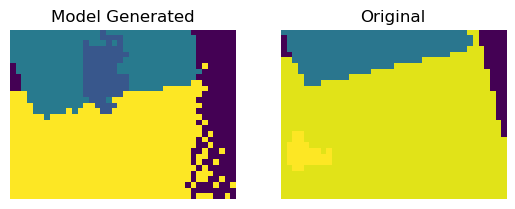

Epoch 1:   0%|          | 0/120 [00:00<?, ?it/s]

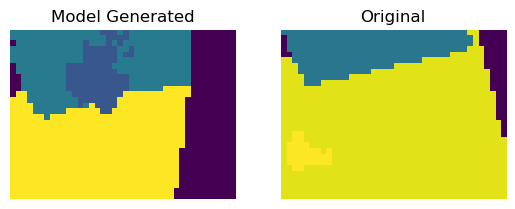

Epoch 2:   0%|          | 0/120 [00:00<?, ?it/s]

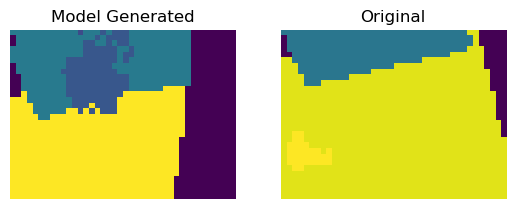

Epoch 3:   0%|          | 0/120 [00:00<?, ?it/s]

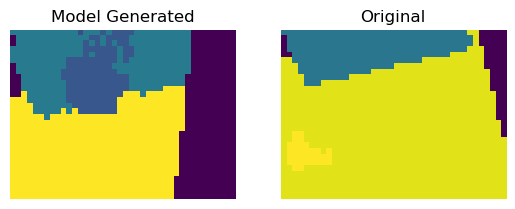

Epoch 4:   0%|          | 0/120 [00:00<?, ?it/s]

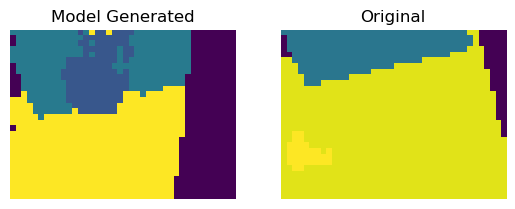

Epoch 5:   0%|          | 0/120 [00:00<?, ?it/s]

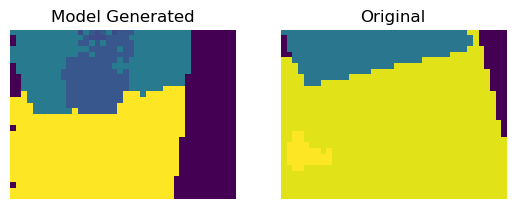

Epoch 6:   0%|          | 0/120 [00:00<?, ?it/s]

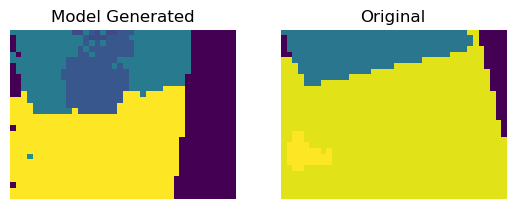

Epoch 7:   0%|          | 0/120 [00:00<?, ?it/s]

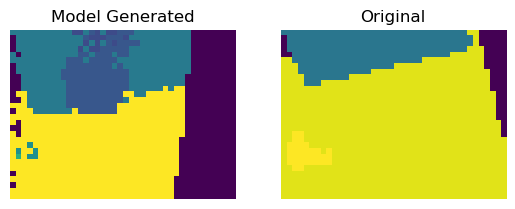

Epoch 8:   0%|          | 0/120 [00:00<?, ?it/s]

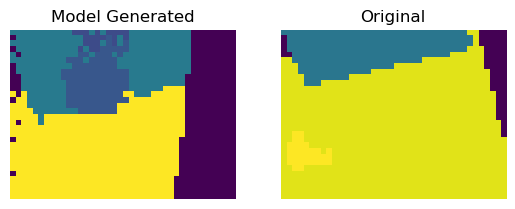

Epoch 9:   0%|          | 0/120 [00:00<?, ?it/s]

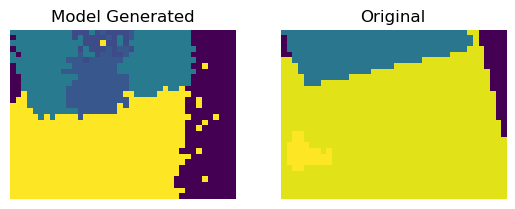

Epoch 10:   0%|          | 0/120 [00:00<?, ?it/s]

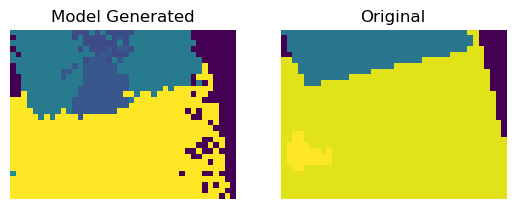

Epoch 11:   0%|          | 0/120 [00:00<?, ?it/s]

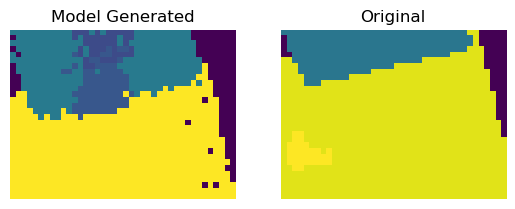

Epoch 12:   0%|          | 0/120 [00:00<?, ?it/s]

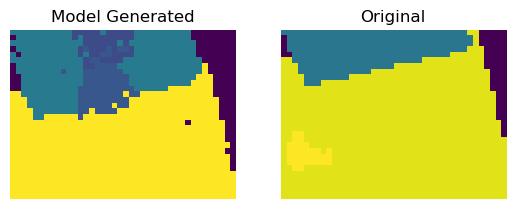

Epoch 13:   0%|          | 0/120 [00:00<?, ?it/s]

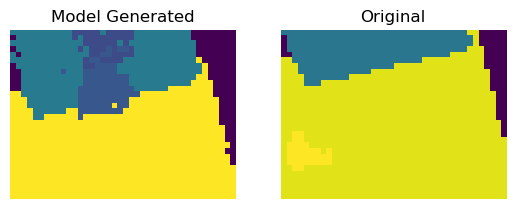

Epoch 14:   0%|          | 0/120 [00:00<?, ?it/s]

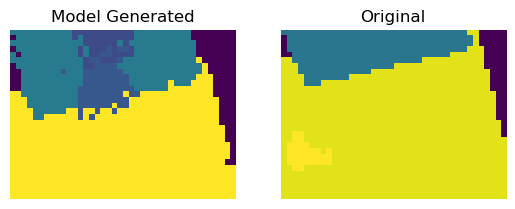

Epoch 15:   0%|          | 0/120 [00:00<?, ?it/s]

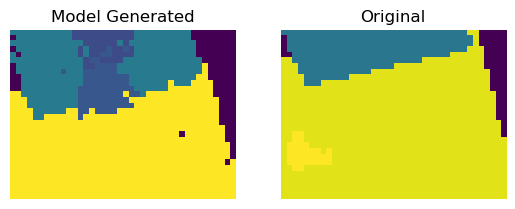

Epoch 16:   0%|          | 0/120 [00:00<?, ?it/s]

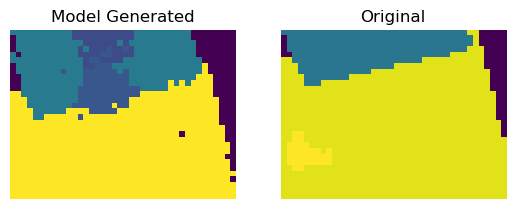

Epoch 17:   0%|          | 0/120 [00:00<?, ?it/s]

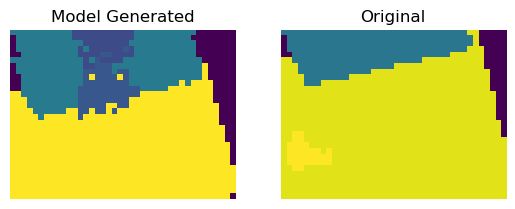

Epoch 18:   0%|          | 0/120 [00:00<?, ?it/s]

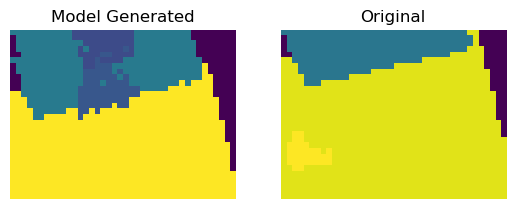

Epoch 19:   0%|          | 0/120 [00:00<?, ?it/s]

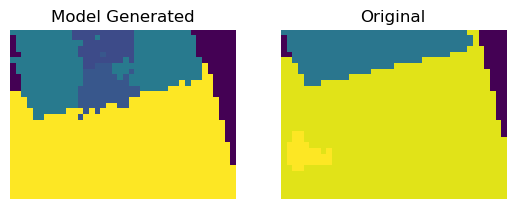

In [81]:
loss_hist = []
test_loss_hist = []
counter = 0

loss = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(net.parameters(), lr=5e-3, betas=(0.9, 0.999))

# Outer training loop
for epoch in range(epochs):
    iter_counter = 0
    
    #train_batch = iter(trainloader)
    train_batch = tqdm(iter(trainloader), desc=f"Epoch {epoch}")

    # Minibatch training loop
    acc_each_batch = []
    for data, masks in train_batch:
        data = data.to(device).to(torch.float)
        masks = masks.to(device).to(torch.float)

        #print(data.shape)
        current_batch_size = data.shape[0]
        #print(data.view(batch_size, -1).shape)
        #print(masks.shape)

        # forward pass
        net.train()
        spk_rec, mem_rec = net(data)

        # initialize the loss & sum over time
        loss_val = torch.zeros((1), dtype=dtype, device=device)
        acc_each_step = []
        for step in range(num_bins_per_frame):
            loss_val += loss(spk_rec[step], masks)

        #     # Getting accuracy
        #     with torch.no_grad():
        #         net.eval()
                
        #         curr_pred_mask = mem_rec[step].argmax(dim=1) # Converted into a mask that isn't one-hot. Dim 1 because 0 is batch size
        #         curr_true_mask = masks.argmax(dim=1)
    
        #         correct_class_mask = (curr_pred_mask == curr_true_mask).to(torch.float)
    
        #         pixel_based_batch_acc = correct_class_mask.count_nonzero() / correct_class_mask.numel()
        #         acc_each_step.append(pixel_based_batch_acc.item())

        
        # acc_each_batch.append(mean(acc_each_step))

        net.train()
        
        # Gradient calculation + weight update
        optimizer.zero_grad()
        loss_val.backward()
        optimizer.step()

        # Store loss history for future plotting
        loss_hist.append(loss_val.item())

    #print(f"Mean Pixel-Based Accuracy for all Steps & Batches: {mean(acc_each_batch)}")

    with torch.no_grad():
        net.eval()
        compare_masks(dataset, index=0, time_step=0)

In [26]:
#torch.save(net, "evimo_img_segmentation_model")

In [19]:
net = torch.load("evimo_img_segmentation_model")

In [20]:
25*30*40*batch_size

120000

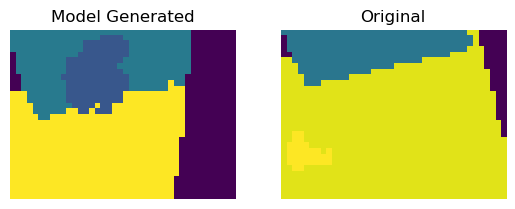

(tensor([[ 9,  9,  9,  ...,  0,  0,  0],
         [ 9,  9,  9,  ...,  0,  0,  0],
         [ 9,  9,  9,  ...,  0,  0,  0],
         ...,
         [22, 22, 22,  ...,  0,  0,  0],
         [22, 22, 22,  ...,  0,  0,  0],
         [22, 22, 22,  ...,  0,  0,  0]], device='cuda:0'),
 tensor([[ 9,  9,  9,  ...,  0,  0,  0],
         [ 0,  9,  9,  ...,  0,  0,  0],
         [ 0,  9,  9,  ...,  0,  0,  0],
         ...,
         [22, 22, 22,  ..., 22, 22, 22],
         [22, 22, 22,  ..., 22, 22, 22],
         [22, 22, 22,  ..., 22, 22, 22]]))

In [80]:
compare_masks(dataset, index=0, time_step=0)

In [22]:
print(net)

Net(
  (fc1): Linear(in_features=307200, out_features=128, bias=True)
  (lif1): Leaky()
  (fc2): Linear(in_features=128, out_features=30000, bias=True)
  (lif2): Leaky()
)


In [23]:
print(net.state_dict())

OrderedDict([('fc1.weight', tensor([[-0.0344,  0.0172,  0.0256,  ..., -0.0739, -0.0443, -0.0340],
        [-0.0342, -0.1113, -0.0363,  ..., -0.0589, -0.0342, -0.0316],
        [-0.0008,  0.0061,  0.0366,  ..., -0.1779, -0.0932, -0.0211],
        ...,
        [-0.0386, -0.0220,  0.0140,  ..., -0.0781, -0.0431, -0.0177],
        [ 0.2198,  0.0445,  0.1861,  ...,  0.0821,  0.1048,  0.0974],
        [-0.0333, -0.0534, -0.0902,  ..., -0.0410, -0.0348, -0.0169]],
       device='cuda:0')), ('fc1.bias', tensor([-0.0802, -0.0643, -0.1076, -0.0793, -0.0866, -0.1526, -0.1271, -0.0076,
        -0.2174, -0.0282, -0.0683, -0.0064,  0.0602, -0.0861,  0.1320, -0.0241,
         0.0292, -0.3047, -0.1237, -0.0170, -0.2514, -0.0245, -0.1506, -0.1569,
        -0.1373,  0.0082, -0.1052,  0.0559, -0.1727, -0.0812, -0.0138, -0.0149,
        -0.0144, -0.0186, -0.0612, -0.0718, -0.0936, -0.0604,  0.0264, -0.1062,
        -0.0885, -0.0129, -0.0895, -0.1246, -0.0863, -0.0274, -0.0400,  0.0096,
        -0.1238,  0

In [118]:
net.state_dict().keys()

odict_keys(['fc1.weight', 'fc1.bias', 'lif1.threshold', 'lif1.graded_spikes_factor', 'lif1.reset_mechanism_val', 'lif1.beta', 'fc2.weight', 'fc2.bias', 'lif2.threshold', 'lif2.graded_spikes_factor', 'lif2.reset_mechanism_val', 'lif2.beta'])

In [123]:
net.state_dict()["lif1.beta"]

tensor(0.9500, device='cuda:0')

In [154]:
e, mask = dataset[0]
e.shape

e[0].view(1, -1).shape

torch.Size([1, 307200])

need ratio such that 1 = 

In [151]:
.6*.4

0.24

In [150]:
.4 -.24

0.16000000000000003

In [153]:
[1, 2, 3][-1]

3

In [157]:
.2*.8

0.16000000000000003

In [156]:
mem1 = net.lif1.init_leaky()
mem2 = net.lif2.init_leaky()

spk1_rec = []
mem1_rec = []
cur1_rec = []

for step in range(num_bins_per_frame):
    x = e[step].view(1, -1).to(device) # Batch size 1.

    cur1 = net.fc1(x)
    cur1_rec.append(cur1)
    spk1, mem1 = net.lif1(cur1, mem1)
    
    if len(spk1_rec) > 0:
        new_spikes = spk1 - spk1_rec[len(spk1_rec)-1]
    else:
        new_spikes = spk1
    
    spike_indices = new_spikes.nonzero(as_tuple=True)[1]

    if len(cur1_rec) >= 3:
        desired_cur = (.6 * cur1_rec[-1] + .3 * cur1_rec[-2] + 0.1 * cur1_rec[-3]) / 3
    elif len(cur1_rec) == 2:
        desired_cur = (0.75 * cur1_rec[-1] + 0.25 * cur1_rec[-2]) / 2
    else:
        desired_cur = cur1_rec[-1]

    #change = desired_cur - cur1

    #print(change.shape)


    #desired_weights = 

    

    




cur1.shape, spk1.shape

torch.Size([1, 128])
torch.Size([1, 128])
torch.Size([1, 128])
torch.Size([1, 128])
torch.Size([1, 128])
torch.Size([1, 128])
torch.Size([1, 128])
torch.Size([1, 128])


(torch.Size([1, 128]), torch.Size([1, 128]))

In [144]:
weights = net.state_dict()["fc1.weight"]
weights.shape

torch.Size([128, 307200])

In [ ]:
weights[spike_indices]

In [142]:
spike_indices

tensor([  0,   1,   2,   6,   9,  10,  16,  20,  23,  24,  27,  28,  29,  30,
         33,  40,  44,  45,  47,  48,  50,  55,  56,  57,  63,  65,  67,  68,
         71,  74,  75,  76,  77,  82,  88,  89,  91,  92,  93,  95,  97, 103,
        104, 105, 106, 108, 111, 112, 116, 123], device='cuda:0')

In [116]:
def update_weights(weights, spk_rec):
    change_factor = 1.2
    
    weights[spk_rec.nonzero(as_tuple=True)[1]] *= change_factor
    weights[(spk_rec == 0).nonzero(as_tuple=True)[1]] /= change_factor

In [117]:
e, mask = dataset[0]

x = e[0].view(1, -1) # Batch size 1.

fc1_out = net.fc1(x.to(device))

mem1 = net.lif1.init_leaky()

spk1, mem1 = net.lif1(fc1_out, mem1)

update_weights(net.state_dict()["fc1.weight"], spk1)

net.state_dict()["fc1.weight"]

tensor([[ 0.0242,  0.0341,  0.0393,  ...,  0.0163,  0.0135,  0.0031],
        [ 0.0044,  0.0104,  0.0372,  ...,  0.0113,  0.0043,  0.0039],
        [ 0.0188,  0.0339,  0.0396,  ...,  0.0152,  0.0092,  0.0015],
        ...,
        [ 0.0227,  0.0230,  0.0219,  ...,  0.0169,  0.0064,  0.0019],
        [ 0.0459,  0.0230,  0.0556,  ..., -0.0033,  0.0116, -0.0591],
        [ 0.0189,  0.0247,  0.0507,  ...,  0.0066, -0.1656, -0.0211]],
       device='cuda:0')

In [115]:
net.fc1.weights

AttributeError: 'Linear' object has no attribute 'weights'

In [ ]:
def cl_forward(self, data):
    # Input data should be in format: Batch size, num_bins_per_frame, channel(1), x, y

    # Initialize hidden states at t=0
    mem1 = self.lif1.init_leaky()
    mem2 = self.lif2.init_leaky()


    spk1_rec = []
    mem1_rec = []
    cur1_rec = []
    
    # Record the final layer
    spk2_rec = []
    mem2_rec = []

    current_batch_size = data.shape[0]
    
    data = data.transpose(0, 1) # Converting to num_bins_per_frame, batch_size, channel, x, y

    for step in range(num_bins_per_frame):
        x = data[step].view(current_batch_size, -1)
        
        cur1 = self.fc1(x)
        cur1_rec.append(cur1)
        spk1, mem1 = self.lif1(cur1, mem1)
        
        if len(spk1_rec) > 0:
            new_spikes = spk1 - spk1_rec[len(spk1_rec)-1]
        else:
            new_spikes = spk1

        spike_indices = new_spikes.nonzero(as_tuple=True)[1]
        
        

        
        

        update_weights(net.state_dict()["fc1.weight"], spk1)

        
        cur2 = self.fc2(spk1)
        spk2, mem2 = self.lif2(cur2, mem2)

        
        spk2_rec.append(spk2.reshape(current_batch_size, num_classes, output_size[0], output_size[1]))
        mem2_rec.append(mem2.reshape(current_batch_size, num_classes, output_size[0], output_size[1]))

    return torch.stack(spk2_rec, dim=0), torch.stack(mem2_rec, dim=0)